
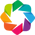

In [1]:
import json
import csv
import glob
import codecs
import string
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import random
import  pickle
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import holoviews as hv
hv.extension('bokeh')

In [2]:
ROOT_PATH = "./Data/"

SOURCE_1_PATH = ROOT_PATH + "now_sources_pt1.full.txt"
SOURCE_2_PATH = ROOT_PATH + "now_sources_pt2.full.txt"

DATA_PATH = ROOT_PATH + "Files/"
FRAMES_PATH = ROOT_PATH + "DataFrames/"
ENCODING = "latin1"

COLUMN_NAMES = ['TextID',
                'Number of Words',
                'Date',
                'Country',
                'Source',
                'Link',
                'Headline']

# OUTLINE

The Notebook will be split between the following sections: 
   #### 1. Data Processing and enrichement of the Data set 
   #### 2. Newspaper Bias analysis with the FastText model as well as a Newral Network 
   #### 3. Word Frequency retrieval with TF-IDF 
   #### 4. Retrieval of polls results and plot for polls results over time
   #### 5. Heat Maps analyzing the Top words over Time (2015 to 2016)
   #### 6. Plot analyzing Word Frequencies deending on Newspaper circultion in the USA and Month



# 1. Data Preprocessing

First, we will obtain our data from the NOW Corpus and add labels from our external sources.

### Scrape Source for Newspaper Bias Ratings

In [3]:
ratings_url = 'https://www.allsides.com/bias/bias-ratings'

# open and load the soup object for the source
hdr = {'User-Agent': 'Mozilla/5.0'}
request = Request(ratings_url, headers=hdr)
page = urlopen(request)
soup = BeautifulSoup(page, "lxml")
links = soup.findAll(attrs={'class':'source-title'})

In [4]:
bias_sources = {}
covert_bias_dic = {
    'Political News Media Bias Rating: Right': 2,
    'Political News Media Bias Rating: Lean Right': 1,
    'Political News Media Bias Rating: Center': 0,
    'Political News Media Bias Rating: Lean Left': -1,
    'Political News Media Bias Rating: Left': -2,
}
    
# find the bias rating for each source and convert it to numerical value
biases = soup.findAll(attrs={'class':'views-field-field-bias-image'})
biases.pop(0)

for i in range(len(biases)):
    source_title = links[i].a.text;
    bias = biases[i].img['title']
    bias_sources[source_title] = covert_bias_dic[bias]

To overcome inconsistencies between the sources from www.allsides.com and the NOW Corpus data, we will rename specific sources in our dictionary.

In [5]:
bias_sources['CNN'] = bias_sources.pop('CNN (Web News)')
bias_sources['Wall Street Journal '] = bias_sources.pop('Wall Street Journal- News')
bias_sources['Huffington Post'] = bias_sources.pop('HuffPost')
bias_sources['NPR'] = bias_sources.pop('NPR News')

print("Source: Bias Rating")
bias_sources

Source: Bias Rating


{'ABC News': -1,
 'Al Jazeera': 0,
 'American Spectator': 2,
 'Associated Press': 0,
 'BBC News': 0,
 'Bloomberg': 0,
 'Breitbart News': 2,
 'Buzzfeed': -1,
 'CBN': 2,
 'CBS News': -1,
 'CNN': 0,
 'CNN - Editorial': -2,
 'Chicago Tribune': 0,
 'Christian Science Monitor': 0,
 'Cook Report': 0,
 'Daily Beast': 0,
 'Daily Kos': -2,
 'Democracy Now': -2,
 'FactCheck.org': 0,
 'Fiscal Times': 1,
 'FiveThirtyEight': 0,
 'Forbes': 0,
 'Foreign Affairs': 0,
 'Fox News': 1,
 'How Do We Fix It?': 0,
 'Huffington Post': -2,
 'Independent Journal Review': 1,
 'Judicial Watch': 1,
 'Los Angeles Times': -1,
 'Media Matters': -2,
 'Media Research Center': 2,
 'Mediaite': -1,
 'Mother Jones': -2,
 'NBCNews.com': -1,
 'NPR': 0,
 'NPR Editorial ': -1,
 'National Journal': 0,
 'National Review': 2,
 'New Republic': -2,
 'New York Post': 2,
 'New York Times': -1,
 'Newsmax': 2,
 'Newsweek': -1,
 'Politico': 0,
 'RealClearPolitics': 0,
 'Reason': 1,
 'Reuters': 0,
 'Salon': -2,
 'Slate': -1,
 'The Atlanti

In [6]:
with open(ROOT_PATH+'enrichment.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader, None)
    enriched_sources = dict((rows[0],rows[1]) for rows in reader)
enriched_sources

{'Business Insider': '-1',
 'CNBC': '-1',
 'CounterPunch': '-2',
 'Daily Caller': '1',
 'Democracy Now!': '-2',
 'Fortune': '1',
 'Hot air': '2',
 'MarketWatch': '0',
 'NPR': '0',
 'Nasdaq': '',
 'New York Daily News': '-1',
 'PoliticusUSA': '-2',
 'Quartz': '-1',
 'Raw Story': '-2',
 'Slate Magazine': '-1',
 'TIME': '-2',
 'TPM': '',
 'The Hill (blog)': '0',
 'The Inquisitr': '-1',
 'The New Yorker': '-2',
 'The Seattle Times': '-1',
 'The Week Magazine': '-1',
 'US News & World Report': '-1',
 'Voice of America': '0'}

However, we shall remove Nasdaq and TPM because they do not have bias ratings.

In [7]:
enriched_sources.pop('Nasdaq')
enriched_sources.pop('TPM')

''

In [8]:
for source in enriched_sources.keys():
    if source not in bias_sources:
        print('Adding ' + source + ' to bias dictionary')
        bias_sources[source] = enriched_sources[source]

Adding Hot air to bias dictionary
Adding Voice of America to bias dictionary
Adding TIME to bias dictionary
Adding The Hill (blog) to bias dictionary
Adding US News & World Report to bias dictionary
Adding Quartz to bias dictionary
Adding MarketWatch to bias dictionary
Adding CNBC to bias dictionary
Adding PoliticusUSA to bias dictionary
Adding Daily Caller to bias dictionary
Adding The Seattle Times to bias dictionary
Adding The Inquisitr to bias dictionary
Adding New York Daily News to bias dictionary
Adding The Week Magazine to bias dictionary
Adding Fortune to bias dictionary
Adding Business Insider to bias dictionary
Adding The New Yorker to bias dictionary
Adding CounterPunch to bias dictionary
Adding Slate Magazine to bias dictionary
Adding Democracy Now! to bias dictionary
Adding Raw Story to bias dictionary


#### Create a DataFrame of all Article Content from January 2015 to October 2016 from NOW Corpus

We are considering this timeframe because it includes the relevant events for the 2016 election cycle from the anouncing of party candidates to the month before the actual election.

In [9]:
filenames = glob.glob(DATA_PATH + "*.txt")
data = []

for file in filenames:
    with codecs.open(file, "r", encoding=ENCODING) as f:
        lines = f.readlines()
        
    for line in lines:
        data.append(line)

# create a dataframe using the list of lines
df_articles = pd.DataFrame(data, columns=["Content"])
print("Total Number of Articles: " + str(len(df_articles["Content"])))
df_articles.head()

Total Number of Articles: 307072


Content
0  @@2930853 <h> 100,000 copies of The Interview ...
1  @@2930854 <h> ' The Taking of Tiger Mountain '...
2  @@2930855 <h> Calculating the cost of a war is...
3  @@2930856 <p> MY PAINED RELATIONSHIP with gove...
4  @@2930859 <h> Pushkin , Gogol and Akhmatova to...

Next, we will separate the article id from the content string in each row.

In [10]:
article_ids = []
for article in range(len(df_articles['Content'])):
    split = df_articles['Content'][article].split('<')
    article_id = split[0]
    article_id = article_id[2:]
    article_id = article_id[:-1]
    try:
        article_id = int(article_id)
        article_ids.append(article_id)
    except:
        article_ids.append(-1)
df_articles['Article_ID'] = article_ids
df_articles.head()

Content  Article_ID
0  @@2930853 <h> 100,000 copies of The Interview ...     2930853
1  @@2930854 <h> ' The Taking of Tiger Mountain '...     2930854
2  @@2930855 <h> Calculating the cost of a war is...     2930855
3  @@2930856 <p> MY PAINED RELATIONSHIP with gove...     2930856
4  @@2930859 <h> Pushkin , Gogol and Akhmatova to...     2930859

We will remove any articles that we were not able to parse the article id from.

In [11]:
df_articles = df_articles[df_articles['Article_ID'] != -1]
print("Number of Articles: " + str(len(df_articles['Content'])))
df_articles.head()

Number of Articles: 306753


Content  Article_ID
0  @@2930853 <h> 100,000 copies of The Interview ...     2930853
1  @@2930854 <h> ' The Taking of Tiger Mountain '...     2930854
2  @@2930855 <h> Calculating the cost of a war is...     2930855
3  @@2930856 <p> MY PAINED RELATIONSHIP with gove...     2930856
4  @@2930859 <h> Pushkin , Gogol and Akhmatova to...     2930859

#### Create a DataFrame of the Sources of the Articles from the Now Corpus Dataset

We are creating a separate dataframe because the sources for all of the articles are provided in a separate file linked with the Text ID.

In [12]:
with codecs.open(SOURCE_2_PATH, "r", encoding="latin1") as f:
    now_sources = pd.read_csv(f, sep="\t", names = COLUMN_NAMES)
    now_sources['TextID'] = pd.to_numeric(now_sources['TextID'])
    now_sources = now_sources[now_sources.Country == "US"]
now_sources.head()

TextID  Number of Words      Date Country                       Source  \
0  2930853              194  15-01-01      US         Consequence of Sound   
1  2930854              266  15-01-01      US            Los Angeles Times   
2  2930855              701  15-01-01      US                         TIME   
3  2930856             1963  15-01-01      US            The Week Magazine   
4  2930859              263  15-01-01      US  Russia Beyond the Headlines   

                                                Link  \
0  http://consequenceofsound.net/2015/01/100000-c...   
1  http://www.latimes.com/entertainment/movies/la...   
2      http://time.com/3651697/afghanistan-war-cost/   
3  http://theweek.com/articles/441310/confessions...   
4  http://rbth.com/arts/2015/01/01/year_of_litera...   

                                            Headline  
0  100000 copies of The Interview will be dropped...  
1  'The Taking of Tiger Mountain' gets blockbuste...  
2  The True Cost of the Afghanistan War May Surpr...  
3                Confessions of a former TSA officer  
4  Pushkin, Gogol and Akhmatova to be symbols of ...

### Analyze the Ratio of Articles and Sources that can be Labeled

In [13]:
sources = set()
bias_sources_dist = {}
articles_biased = []
articles_total = len(now_sources['Source'])
        
for index, row in now_sources.iterrows():
    source = row['Source']
    text_id = int(row['TextID'])
    
#   keep track of unique sources in our NOW dataset
    sources.add(source)
    
    if source in bias_sources.keys():
#       keep track of sources in our bias dictionary and their total no. of articles in our datset
        if source not in bias_sources_dist:
            bias_sources_dist[source] = 0
        
        bias_sources_dist[source] += 1
#       maintain a list of article id's that we have labels for
        articles_biased.append(text_id)

print("Total # of Newspaper Sources in Bias Dictionary: " + str(len(bias_sources_dist.keys())))
print("Total # of Newspaper Sources: " + str(len(sources)))

# print the distribution of the biased sources in our dataset
# print(bias_sources_dist)

Total # of Newspaper Sources in Bias Dictionary: 68
Total # of Newspaper Sources: 7486


In [14]:
# the distribution of the biased sources in our dataset
sorted_bias = sorted(bias_sources_dist.items(), key=operator.itemgetter(1))
sorted_bias

[('Forbes', 1),
 ('National Review', 1),
 ('The Libertarian Republic', 3),
 ('Watchdog.org', 11),
 ('Democracy Now', 12),
 ('Reason', 13),
 ('National Journal', 24),
 ('FactCheck.org', 26),
 ('Western Journalism', 26),
 ('Independent Journal Review', 45),
 ('The Weekly Standard', 47),
 ('New Republic', 77),
 ('American Spectator', 94),
 ('Townhall', 146),
 ('The Federalist', 169),
 ('Daily Kos', 187),
 ('Newsweek', 206),
 ('Newsmax', 225),
 ('New York Times', 242),
 ('RealClearPolitics', 243),
 ('Washington Examiner', 253),
 ('PoliticusUSA', 316),
 ('Democracy Now!', 322),
 ('FiveThirtyEight', 382),
 ('CounterPunch', 399),
 ('Raw Story', 500),
 ('Mother Jones', 508),
 ('Breitbart News', 546),
 ('The Week Magazine', 609),
 ('Mediaite', 609),
 ('Christian Science Monitor', 629),
 ('The Hill (blog)', 652),
 ('Wall Street Journal ', 702),
 ('Slate Magazine', 705),
 ('ThinkProgress', 715),
 ('Politico', 739),
 ('Daily Beast', 750),
 ('Daily Caller', 757),
 ('The Hill', 838),
 ('The New York

We will merge our content and source dataframes.

In [15]:
df_articles = now_sources.set_index('TextID').join(df_articles.set_index('Article_ID'))
df_articles = df_articles.dropna(subset=['Content'])
df_articles = df_articles.reset_index()
df_articles = df_articles.rename(columns={'TextID': 'Article_ID'})

print("Total # of Articles: " + str(len(df_articles['Content'])))
df_articles.head()

Total # of Articles: 303554


Article_ID  Number of Words      Date Country                       Source  \
0     2930853              194  15-01-01      US         Consequence of Sound   
1     2930854              266  15-01-01      US            Los Angeles Times   
2     2930855              701  15-01-01      US                         TIME   
3     2930856             1963  15-01-01      US            The Week Magazine   
4     2930859              263  15-01-01      US  Russia Beyond the Headlines   

                                                Link  \
0  http://consequenceofsound.net/2015/01/100000-c...   
1  http://www.latimes.com/entertainment/movies/la...   
2      http://time.com/3651697/afghanistan-war-cost/   
3  http://theweek.com/articles/441310/confessions...   
4  http://rbth.com/arts/2015/01/01/year_of_litera...   

                                            Headline  \
0  100000 copies of The Interview will be dropped...   
1  'The Taking of Tiger Mountain' gets blockbuste...   
2  The True Cost of the Afghanistan War May Surpr...   
3                Confessions of a former TSA officer   
4  Pushkin, Gogol and Akhmatova to be symbols of ...   

                                             Content  
0  @@2930853 <h> 100,000 copies of The Interview ...  
1  @@2930854 <h> ' The Taking of Tiger Mountain '...  
2  @@2930855 <h> Calculating the cost of a war is...  
3  @@2930856 <p> MY PAINED RELATIONSHIP with gove...  
4  @@2930859 <h> Pushkin , Gogol and Akhmatova to...

Then, we will create a separate dataframe for articles that we can label (their source exists in our dictionary).

In [16]:
df_biased_articles = df_articles[df_articles['Article_ID'].isin(articles_biased)]

print("Number of Articles to Label: " + str(len(df_biased_articles['Content'])))
print("Total # of Articles: " + str(len(df_articles['Content'])))
print("Ratio of Relevant NOW Dataset that can be Labeled: " + str((float(len(df_biased_articles['Content']))/float(len(df_articles['Content'])))))

df_biased_articles.head()

Number of Articles to Label: 72523
Total # of Articles: 303554
Ratio of Relevant NOW Dataset that can be Labeled: 0.23891301053519307


Article_ID  Number of Words      Date Country             Source  \
1     2930854              266  15-01-01      US  Los Angeles Times   
2     2930855              701  15-01-01      US               TIME   
3     2930856             1963  15-01-01      US  The Week Magazine   
5     2930864              199  15-01-01      US             Quartz   
6     2930865             3740  15-01-01      US       The Atlantic   

                                                Link  \
1  http://www.latimes.com/entertainment/movies/la...   
2      http://time.com/3651697/afghanistan-war-cost/   
3  http://theweek.com/articles/441310/confessions...   
5  http://qz.com/320207/piketty-rejects-legion-of...   
6  http://www.theatlantic.com/national/archive/20...   

                                            Headline  \
1  'The Taking of Tiger Mountain' gets blockbuste...   
2  The True Cost of the Afghanistan War May Surpr...   
3                Confessions of a former TSA officer   
5  Piketty rejects Legion of Honor, vindicates Na...   
6           New York's Unfinished Tale of Two Cities   

                                             Content  
1  @@2930854 <h> ' The Taking of Tiger Mountain '...  
2  @@2930855 <h> Calculating the cost of a war is...  
3  @@2930856 <p> MY PAINED RELATIONSHIP with gove...  
5  @@2930864 <p> " I just found out that I had be...  
6  @@2930865 <p> Since he announced his candidacy...

### Label the Articles with Biased Sources

In [17]:
labels = []
for source in df_biased_articles['Source']:
    labels.append(bias_sources[source])
    
df_biased_articles['Bias'] = labels
df_biased_articles.head()

/Users/karunya/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Article_ID  Number of Words      Date Country             Source  \
1     2930854              266  15-01-01      US  Los Angeles Times   
2     2930855              701  15-01-01      US               TIME   
3     2930856             1963  15-01-01      US  The Week Magazine   
5     2930864              199  15-01-01      US             Quartz   
6     2930865             3740  15-01-01      US       The Atlantic   

                                                Link  \
1  http://www.latimes.com/entertainment/movies/la...   
2      http://time.com/3651697/afghanistan-war-cost/   
3  http://theweek.com/articles/441310/confessions...   
5  http://qz.com/320207/piketty-rejects-legion-of...   
6  http://www.theatlantic.com/national/archive/20...   

                                            Headline  \
1  'The Taking of Tiger Mountain' gets blockbuste...   
2  The True Cost of the Afghanistan War May Surpr...   
3                Confessions of a former TSA officer   
5  Piketty rejects Legion of Honor, vindicates Na...   
6           New York's Unfinished Tale of Two Cities   

                                             Content Bias  
1  @@2930854 <h> ' The Taking of Tiger Mountain '...   -1  
2  @@2930855 <h> Calculating the cost of a war is...   -2  
3  @@2930856 <p> MY PAINED RELATIONSHIP with gove...   -1  
5  @@2930864 <p> " I just found out that I had be...   -1  
6  @@2930865 <p> Since he announced his candidacy...   -1

So far we have two dataframes:
* df_articles contains all of the articles from the NOW Corpus Dataset from January 2015 - October 2016
* df_biased_articles contains the subset of df_articles for which we have bias labels from our external source

### Filter Articles For Key Terms for Election

We will filter all of our biased articles and the total available articles for key terms that are relevant to the election cycle. We do this because the NOW Corpus does not match each article with its media genre. For instance, entertainment and sports news are not distinguished from political news.

In [18]:
relevant_keywords = ["election",
                     "trump",
                     "donald"
                     "clinton",
                     "hillary"]

First, we should remove all punctuation and capitalization from the article contents.

In [19]:
# function to replace all the punctuations with a space
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, " ")
    return text

In [88]:
# convert all text to lowercase
df_biased_articles["Content"] = df_biased_articles["Content"].str.lower()

# remove all punctuation
df_biased_articles["Content"] = df_biased_articles["Content"].apply(remove_punctuations)

In [21]:
# convert all text to lowercase
df_articles["Content"] = df_articles["Content"].str.lower()

# remove all punctuation
df_articles["Content"] = df_articles["Content"].apply(remove_punctuations)

Next, filter only for articles that contain the key terms.

In [22]:
# NOTE: add a space between the OR | symbol between the words so
# we do not choose words which have relevant words as substrings
relevant_regex = " |".join(relevant_keywords)

# find all articles which contain any of the relevant keywords
df_biased_articles = df_biased_articles[df_biased_articles["Content"].str.contains(relevant_regex)]
df_articles = df_articles[df_articles["Content"].str.contains(relevant_regex)]

In [23]:
print("Total # of articles: {}".format(df_articles.shape[0]))
df_articles.head()

Total # of articles: 32139


Article_ID  Number of Words      Date Country             Source  \
6      2930865             3740  15-01-01      US       The Atlantic   
9      2930868             1913  15-01-01      US               KQED   
15     2930879             1731  15-01-01      US  Voice of America    
20     2930888             1261  15-01-01      US     The New Yorker   
22     2930890              641  15-01-01      US                CNN   

                                                 Link  \
6   http://www.theatlantic.com/national/archive/20...   
9   http://ww2.kqed.org/news/2015/01/01/the-most-i...   
15  http://learningenglish.voanews.com/content/top...   
20  http://www.newyorker.com/news/daily-comment/ne...   
22  http://www.cnn.com/2015/01/01/politics/clinton...   

                                             Headline  \
6            New York's Unfinished Tale of Two Cities   
9      The Most Important New California Laws of 2015   
15                           Top News Stories of 2014   
20  The Newtown Lawsuit and the Moral Work of Gun ...   
22               Hillary Clinton's point of no return   

                                              Content  
6     2930865  p  since he announced his candidacy...  
9     2930868  p  more than 900 new laws are hitti...  
15    2930879  h  top news stories of 2014  p  in ...  
20    2930888  h  the newtown lawsuit and the mora...  
22    2930890  h  hillary clinton  s point of no r...

In [24]:
print("Total # of biased articles: {}".format(df_biased_articles.shape[0]))
df_biased_articles.head()

Total # of biased articles: 13034


Article_ID  Number of Words      Date Country          Source  \
6      2930865             3740  15-01-01      US    The Atlantic   
20     2930888             1261  15-01-01      US  The New Yorker   
22     2930890              641  15-01-01      US             CNN   
31     2930906              501  15-01-01      US        CBS News   
36     2930911             1207  15-01-01      US     NBCNews.com   

                                                 Link  \
6   http://www.theatlantic.com/national/archive/20...   
20  http://www.newyorker.com/news/daily-comment/ne...   
22  http://www.cnn.com/2015/01/01/politics/clinton...   
31  http://www.cbsnews.com/news/first-baby-of-2015...   
36  http://www.nbcnews.com/politics/congress/six-m...   

                                             Headline  \
6            New York's Unfinished Tale of Two Cities   
20  The Newtown Lawsuit and the Moral Work of Gun ...   
22               Hillary Clinton's point of no return   
31    First baby of 2015? Why we'll never really know   
36           Six Members of Congress To Watch in 2015   

                                              Content Bias  
6     2930865  p  since he announced his candidacy...   -1  
20    2930888  h  the newtown lawsuit and the mora...   -2  
22    2930890  h  hillary clinton  s point of no r...    0  
31    2930906  h  web shows  h  resources  h  firs...   -1  
36    2930911  h  six members of congress to watch...   -1

Now that we have updated our dataset to only include articles from January 2015 - October 2016 that are relevant to the U.S 2016 Election, let's see how our ratio of articles that are labeled to total articles has changed.

In [25]:
print("Ratio of Labeled Articles to Total: " + str((float(len(df_biased_articles['Content']))/float(len(df_articles['Content'])))))

Ratio of Labeled Articles to Total: 0.4055508883288217


#### Split the Date Column into Month and Year Columns

To make time series filtering an easier task, we will incorporate date information into separate columns.

In [26]:
df_split = pd.DataFrame(df_biased_articles.Date.str.split('-',2).tolist(), columns = ['Year', 'Month', 'Day'])
df_split.reset_index(drop=True, inplace=True)
df_biased_articles.reset_index(drop=True, inplace=True)
df_biased_articles = pd.concat([df_biased_articles, df_split], axis=1)
df_biased_articles.head()

Article_ID  Number of Words      Date Country          Source  \
0     2930865             3740  15-01-01      US    The Atlantic   
1     2930888             1261  15-01-01      US  The New Yorker   
2     2930890              641  15-01-01      US             CNN   
3     2930906              501  15-01-01      US        CBS News   
4     2930911             1207  15-01-01      US     NBCNews.com   

                                                Link  \
0  http://www.theatlantic.com/national/archive/20...   
1  http://www.newyorker.com/news/daily-comment/ne...   
2  http://www.cnn.com/2015/01/01/politics/clinton...   
3  http://www.cbsnews.com/news/first-baby-of-2015...   
4  http://www.nbcnews.com/politics/congress/six-m...   

                                            Headline  \
0           New York's Unfinished Tale of Two Cities   
1  The Newtown Lawsuit and the Moral Work of Gun ...   
2               Hillary Clinton's point of no return   
3    First baby of 2015? Why we'll never really know   
4           Six Members of Congress To Watch in 2015   

                                             Content Bias Year Month Day  
0    2930865  p  since he announced his candidacy...   -1   15    01  01  
1    2930888  h  the newtown lawsuit and the mora...   -2   15    01  01  
2    2930890  h  hillary clinton  s point of no r...    0   15    01  01  
3    2930906  h  web shows  h  resources  h  firs...   -1   15    01  01  
4    2930911  h  six members of congress to watch...   -1   15    01  01

In [27]:
df_split = pd.DataFrame(df_articles.Date.str.split('-',2).tolist(), columns = ['Year', 'Month', 'Day'])
df_split.reset_index(drop=True, inplace=True)
df_articles.reset_index(drop=True, inplace=True)
df_articles = pd.concat([df_articles, df_split], axis=1)
df_articles.head()

Article_ID  Number of Words      Date Country             Source  \
0     2930865             3740  15-01-01      US       The Atlantic   
1     2930868             1913  15-01-01      US               KQED   
2     2930879             1731  15-01-01      US  Voice of America    
3     2930888             1261  15-01-01      US     The New Yorker   
4     2930890              641  15-01-01      US                CNN   

                                                Link  \
0  http://www.theatlantic.com/national/archive/20...   
1  http://ww2.kqed.org/news/2015/01/01/the-most-i...   
2  http://learningenglish.voanews.com/content/top...   
3  http://www.newyorker.com/news/daily-comment/ne...   
4  http://www.cnn.com/2015/01/01/politics/clinton...   

                                            Headline  \
0           New York's Unfinished Tale of Two Cities   
1     The Most Important New California Laws of 2015   
2                           Top News Stories of 2014   
3  The Newtown Lawsuit and the Moral Work of Gun ...   
4               Hillary Clinton's point of no return   

                                             Content Year Month Day  
0    2930865  p  since he announced his candidacy...   15    01  01  
1    2930868  p  more than 900 new laws are hitti...   15    01  01  
2    2930879  h  top news stories of 2014  p  in ...   15    01  01  
3    2930888  h  the newtown lawsuit and the mora...   15    01  01  
4    2930890  h  hillary clinton  s point of no r...   15    01  01

#### Lemmatization

In this section, we will complete the second part of the preprocessing by lemmatization and consider only the words from the NOW Corpus WLP Dictionary for our analysis. We will open the lemmatization dataframes and merge our current article dataframes on the Article_ID columns.

In [28]:
filenames = glob.glob(ROOT_PATH +"./WLP/" + "*.pkl")
df_wlp = pd.DataFrame()

for file in filenames:
    with open(file, "rb") as pickle_file:
        wlp = pickle.load(pickle_file)
        df_wlp = pd.concat([df_wlp, wlp], ignore_index=True)
        
df_wlp = df_wlp.rename(columns={'Text_ID': 'Article_ID', 'Content': 'wlp'})
df_wlp['Article_ID'] = df_wlp['Article_ID'].apply(pd.to_numeric)
df_wlp.head()

wlp  Article_ID
0  copy interview drop north korea use balloon sh...     2930853
1  taking tiger mountain blockbuster treatment re...     2930854
2  calculate cost war little like find true cost ...     2930855
3  pained relationship government security start ...     2930856
4  pushkin gogol akhmatova symbol russia year lit...     2930859

#### Include bigrams and trigrams 

In [ ]:
DATA_PATH='./Karunya/'
df=pickle.load(open(DATA_PATH+'df_bias_sources_wlp','rb'))

In [ ]:
#Preprocess
#Correct Month 
df['Month']=df['Year']+'-'+df['Month']
#Add bigrams
from nltk.util import ngrams
bigrammed_docs=[]
for c, doc in enumerate(df['wlp']):
    tmp=doc.split()
    doc=(' '.join(tmp + [str("_".join(w)) for w in nltk.bigrams(tmp)]))
    bigrammed_docs.append(doc)
df['bigram_wlp']=bigrammed_docs

#Add Trigram
from nltk.util import ngrams
trigrammed_docs=[]
for c, doc in enumerate(df['wlp']):
    tmp=doc.split()
    doc=(' '.join(df.loc[c,'bigram_wlp'].split() + [str("_".join(w)) for w in ngrams(tmp,3)]))
    trigrammed_docs.append(doc)
df['trigrammed_docs']=trigrammed_docs

pickle.dump(open(FRAMES_PATH+'df_articles_wlp_grams', 'rb'))

In [29]:
df_wlp_grams = pickle.load(open(FRAMES_PATH+'df_articles_wlp_grams', 'rb'))

df_wlp_grams = df_wlp_grams[['TextID', 'bigram_wlp', 'trigrammed_docs']]
df_wlp_grams = df_wlp_grams.rename(columns={'TextID': 'Article_ID', 'trigrammed_docs': 'trigram_wlp'})
df_wlp_grams.head()

Article_ID                                         bigram_wlp  \
0     2930865  announce candidacy mayor new york city january...   
1     2930868  new law hit book annual list important interes...   
2     2930879  news story tuesday oct file photo man suffer e...   
3     2930888  newtown lawsuit moral work gun control news pa...   
4     2930890  hillary clinton point return story highlight d...   

                                         trigram_wlp  
0  announce candidacy mayor new york city january...  
1  new law hit book annual list important interes...  
2  news story tuesday oct file photo man suffer e...  
3  newtown lawsuit moral work gun control news pa...  
4  hillary clinton point return story highlight d...

In [30]:
df_biased_articles = pd.merge(df_biased_articles, df_wlp, on=['Article_ID'], how='left')
df_biased_articles = pd.merge(df_biased_articles, df_wlp_grams, on=['Article_ID'], how='left')
df_biased_articles.head()

Article_ID  Number of Words      Date Country          Source  \
0     2930865             3740  15-01-01      US    The Atlantic   
1     2930888             1261  15-01-01      US  The New Yorker   
2     2930890              641  15-01-01      US             CNN   
3     2930906              501  15-01-01      US        CBS News   
4     2930911             1207  15-01-01      US     NBCNews.com   

                                                Link  \
0  http://www.theatlantic.com/national/archive/20...   
1  http://www.newyorker.com/news/daily-comment/ne...   
2  http://www.cnn.com/2015/01/01/politics/clinton...   
3  http://www.cbsnews.com/news/first-baby-of-2015...   
4  http://www.nbcnews.com/politics/congress/six-m...   

                                            Headline  \
0           New York's Unfinished Tale of Two Cities   
1  The Newtown Lawsuit and the Moral Work of Gun ...   
2               Hillary Clinton's point of no return   
3    First baby of 2015? Why we'll never really know   
4           Six Members of Congress To Watch in 2015   

                                             Content Bias Year Month Day  \
0    2930865  p  since he announced his candidacy...   -1   15    01  01   
1    2930888  h  the newtown lawsuit and the mora...   -2   15    01  01   
2    2930890  h  hillary clinton  s point of no r...    0   15    01  01   
3    2930906  h  web shows  h  resources  h  firs...   -1   15    01  01   
4    2930911  h  six members of congress to watch...   -1   15    01  01   

                                                 wlp  \
0  announce candidacy mayor new york city january...   
1  newtown lawsuit moral work gun control news pa...   
2  hillary clinton point return story highlight d...   
3  web resource baby know bye bye baby new year c...   
4  member congress watch dynamics congress change...   

                                          bigram_wlp  \
0  announce candidacy mayor new york city january...   
1  newtown lawsuit moral work gun control news pa...   
2  hillary clinton point return story highlight d...   
3  web resource baby know bye bye baby new year c...   
4  member congress watch dynamics congress change...   

                                         trigram_wlp  
0  announce candidacy mayor new york city january...  
1  newtown lawsuit moral work gun control news pa...  
2  hillary clinton point return story highlight d...  
3  web resource baby know bye bye baby new year c...  
4  member congress watch dynamics congress change...

In [31]:
df_articles = pd.merge(df_articles, df_wlp, on=['Article_ID'], how='left')
df_articles = pd.merge(df_articles, df_wlp_grams, on=['Article_ID'], how='left')
df_articles.head()

Article_ID  Number of Words      Date Country             Source  \
0     2930865             3740  15-01-01      US       The Atlantic   
1     2930868             1913  15-01-01      US               KQED   
2     2930879             1731  15-01-01      US  Voice of America    
3     2930888             1261  15-01-01      US     The New Yorker   
4     2930890              641  15-01-01      US                CNN   

                                                Link  \
0  http://www.theatlantic.com/national/archive/20...   
1  http://ww2.kqed.org/news/2015/01/01/the-most-i...   
2  http://learningenglish.voanews.com/content/top...   
3  http://www.newyorker.com/news/daily-comment/ne...   
4  http://www.cnn.com/2015/01/01/politics/clinton...   

                                            Headline  \
0           New York's Unfinished Tale of Two Cities   
1     The Most Important New California Laws of 2015   
2                           Top News Stories of 2014   
3  The Newtown Lawsuit and the Moral Work of Gun ...   
4               Hillary Clinton's point of no return   

                                             Content Year Month Day  \
0    2930865  p  since he announced his candidacy...   15    01  01   
1    2930868  p  more than 900 new laws are hitti...   15    01  01   
2    2930879  h  top news stories of 2014  p  in ...   15    01  01   
3    2930888  h  the newtown lawsuit and the mora...   15    01  01   
4    2930890  h  hillary clinton  s point of no r...   15    01  01   

                                                 wlp  \
0  announce candidacy mayor new york city january...   
1  new law hit book annual list important interes...   
2  news story tuesday oct file photo man suffer e...   
3  newtown lawsuit moral work gun control news pa...   
4  hillary clinton point return story highlight d...   

                                          bigram_wlp  \
0  announce candidacy mayor new york city january...   
1  new law hit book annual list important interes...   
2  news story tuesday oct file photo man suffer e...   
3  newtown lawsuit moral work gun control news pa...   
4  hillary clinton point return story highlight d...   

                                         trigram_wlp  
0  announce candidacy mayor new york city january...  
1  new law hit book annual list important interes...  
2  news story tuesday oct file photo man suffer e...  
3  newtown lawsuit moral work gun control news pa...  
4  hillary clinton point return story highlight d...

We will pickle our current dataframes for so we can reload for future processing and analysis.

In [32]:
df_biased_articles.to_pickle(FRAMES_PATH+'df_biased_articles')
df_articles.to_pickle(FRAMES_PATH+'df_articles')

# 2. Data Analysis

We can unpickle our current dataframes for the data analysis portion.

In [33]:
df_biased_articles = pickle.load(open(FRAMES_PATH+'df_biased_articles', 'rb'))
df_articles = pickle.load(open(FRAMES_PATH+'df_articles', 'rb'))

## FastText

FastText is a library created by Facebook for efficient learning of word representations and sentence classification. We will use it to train our dataset and generate bias predictions for articles.

In [34]:
def split_data(data, split=0.8):
    '''
    Split's data into training and testing.
    '''
    # obtain X, Y matrices
    X, Y = data['wlp'], data['Bias']
    
    # permute so we mix positve and negative
    permute = np.random.permutation(len(X))
    X = X[permute]
    Y = Y[permute]
    
    # split X and Y into train and validation sets
    trainX, trainY = X[:int(split * (len(X)))], Y[:int(split * (len(Y)))]
    testX, testY = X[int(split * (len(X))):], Y[int(split * (len(Y))):]
    
    return trainX, trainY, testX, testY

def create_fasttext_input(dataX, dataY, filename, method):
    '''
    Writes data into fastText input file.
    '''
    data = []
    
    for idx in dataX.index.tolist():
        if method == 'left right':
            if(dataY[idx] == -2):
                data.append(("__label__" + str(-1), dataX[idx]))
            if(dataY[idx] == 2):
                data.append(("__label__" + str(1), dataX[idx]))
        
        if method == 'left center right':
            if(dataY[idx] == -2):
                data.append(("__label__" + str(-1), dataX[idx]))
            if(dataY[idx] == 0):
                data.append(("__label__" + str(0), dataX[idx]))
            if(dataY[idx] == 2):
                data.append(("__label__" + str(1), dataX[idx]))
        
        if method == 'left bulk right':
            if(dataY[idx] == -2):
                data.append(("__label__" + str(-1), dataX[idx]))
            if(dataY[idx] == -1 or dataY[idx] == 0 or dataY[idx] == 1):
                data.append(("__label__" + str(0), dataX[idx]))
            if(dataY[idx] == 2):
                data.append(("__label__" + str(1), dataX[idx]))
        
        if method == 'all':
            data.append(("__label__" + str(dataY[idx]), dataX[idx]))
   
    with open(ROOT_PATH+'FastText/'+filename, 'w') as file:
        for item in data:
            line = item[0] + ', ' + item[1]
            file.write(line + '\n')

In [35]:
# split 80% of data into training and 20% into testing
trainX, trainY, testX, testY = split_data(df_biased_articles)

In [36]:
def create_training_file(filename):
    '''
    Creatings a training file from all of the biased articles.
    '''
    training_data = df_biased_articles['wlp']

    with open(ROOT_PATH+filename, 'w') as file:
        for item in training_data:
            line = item
            file.write(line + '\n')

In [37]:
# create a training and testing data input file
method_options = ['left right', 'left center right', 'left bulk right', 'all']

# make sure to test each of the options in the array and generate predictions
method = method_options[3]

create_fasttext_input(trainX, trainY, 'train.txt', method)
create_fasttext_input(testX, testY, 'test.txt', method)
create_training_file('FastText/training_data.txt')

Here are the accuracies using fastText to generate predictions for our test split from the labeled portion of the dataset.

In [38]:
df_fastText = pd.DataFrame(columns=['Labels', 'Accuracy'])
df_fastText.loc[0] = ['Left, Right Newspapers', 0.789]
df_fastText.loc[1] = ['Left, Center, Right Newspapers', 0.706]
df_fastText.loc[2] = ['Left, Bulk*, Right ', 0.771]
df_fastText.loc[3] = ['Left, Left-Leaning, Center, Right-Leaning, Right', 0.574]
df_fastText = df_fastText.set_index('Labels')
df_fastText.head()

Accuracy
Labels                                                    
Left, Right Newspapers                               0.789
Left, Center, Right Newspapers                       0.706
Left, Bulk*, Right                                   0.771
Left, Left-Leaning, Center, Right-Leaning, Right     0.574

In [39]:
labels = pd.read_csv(ROOT_PATH+'/FastText/predictions-5.txt',header=None)
labels = labels[0]

# add predicted bias label column to our dataframe
df_biased_articles['Predicted Bias'] = labels
df_biased_articles['Predicted Bias'] = df_biased_articles['Predicted Bias'].map(lambda x: x.lstrip('__label__'))
df_biased_articles['Bias'] = df_biased_articles['Bias'].astype(int)
df_biased_articles['Predicted Bias'] = df_biased_articles['Predicted Bias'].astype(int)
df_biased_articles.head()

Article_ID  Number of Words      Date Country          Source  \
0     2930865             3740  15-01-01      US    The Atlantic   
1     2930888             1261  15-01-01      US  The New Yorker   
2     2930890              641  15-01-01      US             CNN   
3     2930906              501  15-01-01      US        CBS News   
4     2930911             1207  15-01-01      US     NBCNews.com   

                                                Link  \
0  http://www.theatlantic.com/national/archive/20...   
1  http://www.newyorker.com/news/daily-comment/ne...   
2  http://www.cnn.com/2015/01/01/politics/clinton...   
3  http://www.cbsnews.com/news/first-baby-of-2015...   
4  http://www.nbcnews.com/politics/congress/six-m...   

                                            Headline  \
0           New York's Unfinished Tale of Two Cities   
1  The Newtown Lawsuit and the Moral Work of Gun ...   
2               Hillary Clinton's point of no return   
3    First baby of 2015? Why we'll never really know   
4           Six Members of Congress To Watch in 2015   

                                             Content  Bias Year Month Day  \
0    2930865  p  since he announced his candidacy...    -1   15    01  01   
1    2930888  h  the newtown lawsuit and the mora...    -2   15    01  01   
2    2930890  h  hillary clinton  s point of no r...     0   15    01  01   
3    2930906  h  web shows  h  resources  h  firs...    -1   15    01  01   
4    2930911  h  six members of congress to watch...    -1   15    01  01   

                                                 wlp  \
0  announce candidacy mayor new york city january...   
1  newtown lawsuit moral work gun control news pa...   
2  hillary clinton point return story highlight d...   
3  web resource baby know bye bye baby new year c...   
4  member congress watch dynamics congress change...   

                                          bigram_wlp  \
0  announce candidacy mayor new york city january...   
1  newtown lawsuit moral work gun control news pa...   
2  hillary clinton point return story highlight d...   
3  web resource baby know bye bye baby new year c...   
4  member congress watch dynamics congress change...   

                                         trigram_wlp  Predicted Bias  
0  announce candidacy mayor new york city january...              -1  
1  newtown lawsuit moral work gun control news pa...              -2  
2  hillary clinton point return story highlight d...               0  
3  web resource baby know bye bye baby new year c...              -1  
4  member congress watch dynamics congress change...              -1

For our visualization, we will show the results using different labeling methods for the top 23 sources in our biased dataset.

In [40]:
major_sources = ['Fortune',
                 'Washington Times',
                 'Fox News',
                 'Bloomberg', 
                 'CNN',
                 'CBS News', 
                 'The Inquisitr',
                 'The Seattle Times', 
                 'Business Insider',
                 'CNBC',
                 'Reuters',
                 'NBCNews.com',
                 'New York Daily News',
                 'MarketWatch',
                 'Quartz',
                 'New York Post',
                 'ABC News',
                 'TIME',
                 'Chicago Tribune', 
                 'USA TODAY',
                 'NPR', 
                 'Huffington Post',
                 'Los Angeles Times']

In [41]:
df_bars = df_biased_articles[df_biased_articles['Source'].isin(major_sources)]
df_bars = df_bars.groupby(['Source', 'Predicted Bias']).count()[['Article_ID']]
df_bars = df_bars.rename(columns={'Article_ID': 'Count'})
df_bars = pd.pivot_table(df_bars, values = 'Count', index='Source', columns='Predicted Bias')
df_bars

Predicted Bias          -2     -1      0      1      2
Source                                                
ABC News              12.0  372.0   20.0    8.0    5.0
Bloomberg              3.0   15.0  208.0    NaN    NaN
Business Insider       3.0  145.0   10.0    2.0    3.0
CBS News               5.0  220.0   26.0    3.0    1.0
CNBC                   5.0  174.0   20.0    3.0    3.0
CNN                   10.0    9.0  357.0    4.0    2.0
Chicago Tribune        9.0   19.0  309.0    1.0    1.0
Fortune               12.0   18.0   13.0  125.0    4.0
Fox News               6.0   12.0   15.0  179.0    7.0
Huffington Post      522.0   46.0   27.0    3.0    4.0
Los Angeles Times     17.0  660.0   40.0    6.0    4.0
MarketWatch            9.0   14.0  180.0    5.0    1.0
NBCNews.com            6.0  338.0   18.0    1.0    4.0
NPR                    7.0    9.0  398.0    2.0    1.0
New York Daily News    7.0  162.0   11.0    5.0    2.0
New York Post          8.0   13.0   19.0    8.0  220.0
Quartz                 5.0  211.0   10.0    1.0    1.0
Reuters                4.0   10.0  133.0    3.0    2.0
TIME                 285.0    8.0   16.0    1.0    2.0
The Inquisitr          9.0  172.0    3.0    NaN    4.0
The Seattle Times      5.0  170.0   14.0    2.0    NaN
USA TODAY              7.0   25.0  373.0    8.0    3.0
Washington Times      10.0   12.0   16.0  379.0    7.0

In [42]:
df_bars.to_csv(ROOT_PATH+'barplot_5labels.csv')

## LSTM 

In this section we will compare FastText with a bidirectional LSTM Recurrent Network. The LSTM cell has been shown to perform very well on text as well as the recurrent framework. 

In [3]:
import tflearn as tf
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.layers.recurrent import bidirectional_rnn, BasicLSTMCell
import pickle
from tensorflow.contrib.tensorboard.plugins import projector
from itertools import combinations_with_replacement, permutations


We tried to perform classification with 5 'bias' (or political orientation classes). However the model did not seam to learn. Therefore we performed the LSTM with the two extreme classes only. 
We ran a bidirectional LSTM with two branches

In [ ]:
#Get extreme left and right 'biases'
df=df[np.abs(df['Bias'])>=2 ]


num_train_tweets=df.shape[0]

In [ ]:
#Generate Datasets
def generateX_Y(data,num_classes):
    '''
    Preprocess and generate features for the data, and return X and Y 
    
    INPUT:
        data: dataframe with data. Y values are in column smile, and tweets in column Tweet
        preprocessing_options: dictionary with arguments for preprocessing_tweet function
    OUTPUT:
        features of X, Y, number of features, features, and vectorizer
    '''
    #Separate in X and Y
    X, Y = data['wlp'],data['Bias']
    #Apply preprocessing
    #X['Content'] =X['Content'].apply(preprocess_tweet, **preprocessing_options)
    #Convert 1 to categorical
    Y = to_categorical(Y,nb_classes=num_classes)
    
    #Initialize tokenizer for vectorizer
    tknzr = TweetTokenizer()
    #Generate vectorizer for obtaining features
    vectorizer = CountVectorizer(tokenizer=tknzr.tokenize)#min_df=5)
    #Obtain the features for X
    bag_trainX = vectorizer.fit_transform(data['Content'])
    features=vectorizer.get_feature_names() #Get features names
    num_vocab = len(features) #Number of features
    
    bag_of_ids_trainX = {"bag": [], 'max_len': bag_trainX.shape[1]}
    for bag in bag_trainX:
        bag_of_ids_trainX['bag'].append(np.where(bag.toarray() > 0)[1])
    bag_of_ids_trainX['bag'] = pad_sequences(bag_of_ids_trainX['bag'], maxlen=100)

    return bag_of_ids_trainX['bag'], Y,num_vocab,features,vectorizer
  

In [ ]:
#Get Training and Testing Set
def divide_train_test(df, num_classes):
    '''
    Divide data in train, validation and test  sets
    
    INPUT:
        df_full: dataframe with all data, first training and then test set
        num_train_tweeets: number of tweets in training set
        prep_option: dictionary with arguments for preprocessing_tweet function
    OUTPUT:
        trainX, trainY, valX, valY, testX, number of features, features
    
    '''
    
    #Obtain X, Y matrices
    X, Y,num_vocab,features,vectorizer = generateX_Y(df,num_classes)
    
    #Permute so we mix positve and negative
    permute = np.random.permutation(len(X))
    X = X[permute]
    Y = Y[permute]
    
    #Split X and Y into train and validation sets
    fraction_val=0.8
    trainX , trainY = X[:int(fraction_val*(len(X)))],Y[:int(fraction_val*(len(Y)))]
    valX , valY = X[int(fraction_val*(len(X))):],Y[int(fraction_val*(len(Y))):]
    
    return trainX,trainY,valX,valY,num_vocab, features

num_classes=2
trainX,trainY,testX,testY,num_vocab, features=divide_train_test(df,num_classes)


In [ ]:
#Create Model
def create_bidir_LSTM(learning_rate,num_hidden,num_classes):
    '''
    Create Bidirectional LSTM with tensorflow
    
    OUTPUT:
        model
    '''
    keras.backend.clear_session()
    #Create SentimentalAnalysis Layer(LSTM)
    #tensorflow.reset_default_graph()
    #Input layer
    net = tf.input_data([None, 100] ,name='input_layer')
    #Embedding
    net = tf.embedding(net, input_dim=num_vocab, output_dim=num_hidden,name='embedded_layer')
    
    #Bidirectional branch
    net1 = tf.bidirectional_rnn(net,BasicLSTMCell(num_hidden), BasicLSTMCell(num_hidden),return_seq=True)
    net1 = tf.dropout(net,0.7) #Dropout
    net1 = tf.fully_connected(net1, 150, activation='relu',name='first_fc',regularizer='L2') #Fully connected layer

    #LTSM branch with dropout
    net2 = tf.lstm(net, num_hidden, dropout = 0.8,name = 'LSTM_layer',return_seq=True)
    #If 3d array not returned, stack into a 3D array
    if isinstance(net2, list):
        net2 = tensorflow.stack(net2, axis=1)
    net2 = tf.fully_connected(net2, 200, activation='relu',name='second_fc',regularizer='L2') #Fully connected layer

    #Concatenate the results from each branch to avoid overfitting
    net_final=tensorflow.concat([net1,net2],1, name="concat")
    #Connect all the cells with softmax
    net_final = tf.fully_connected(net_final, num_classes, activation='softmax',name='output')
    #Obtain output with categorical cross entropy
    net_final = tf.regression(net_final, optimizer='adam', learning_rate=learning_rate,
                             loss='categorical_crossentropy')
    tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True,\
                                          embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=features)

    #model = tf.DNN(net_final, tensorboard_verbose=0,checkpoint_path='/tmp/tflearn_logs/model/model.tfl.ckpt')
    return model


In [ ]:
#Load the data from this preprocessing option
# trainX,trainY,testX,testY,X_test,num_vocab,features = pickle.load(open('train_test_prep_'+str(n),'rb'))

#Set Parameters
learning_rate = 0.001
num_hidden = 200  #2*embedding layer size
training_steps=10
batch_size=70
display_step = 400
num_classes = 2

#Create LSTM model
model=create_bidir_LSTM(learning_rate,num_hidden,num_classes)

# Use the same LOG_DIR where you stored your checkpoint.
summary_writer = tensorflow.summary.FileWriter('/tmp/tflearn_logs/model/')

# Format: tensorflow/contrib/tensorboard/plugins/projector/projector_config.proto
config = projector.ProjectorConfig()
# You can add multiple embeddings. Here we add only one.
embedding = config.embeddings.add()
embedding.tensor_name = 'embedded_layer/W'
# Link this tensor to its metadata file (e.g. labels).
pd.Series(features).to_csv('/tmp/tflearn_logs/model/metadata.tsv',sep='\n',index=False,header=False)
embedding.metadata_path = '/tmp/tflearn_logs/model/metadata.tsv'
# Saves a configuration file that TensorBoard will read during startup.
projector.visualize_embeddings(summary_writer, config)

#Training for n_epoch, using batch_size samples per step and showing the validation accuracy every snapshot_step training steps
model.fit(trainX, trainY,validation_set=(testX,testY),n_epoch=training_steps, batch_size=batch_size,
         show_metric=True,snapshot_step=display_step,snapshot_epoch=True)

model.save('/tmp/tflearn_logs/model/model_saved_'+'.ckpt')
acc=model.evaluate (testX, testY, batch_size=batch_size)

pickle.dump([acc],open('model_20171212_22_.pkl','wb'))   

This model got 71% accuracy. So fast Test performed much better. In the future, this model could have been optimized with different word embeddings and different dropout/regularization parameters. 

# 3. Obtention Frequency Tables with TF-IDF

In this section, we create different Tables for plotting: 
    - A word Frequency Table per month 
    - A word Frequency Table per Newspaper
    - A word Frequency Table per Newspaper and per month
    - A word Frequency table for the whole corpus
TF-IDF was choosen as it performs regularizations for common words

### Create the word frequency table per month 

In [ ]:
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')
import codecs, string, os,  random, nltk, gensim, sklearn#, spacy 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
# to support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import pyLDAvis.gensim
from nltk.tokenize import TweetTokenizer
seed = 12345
random.seed(seed)
random_seed(seed)
np.random.seed(seed)
import pickle

In [ ]:

FILES_PATH='/Users/laurieprelot/Documents/EPFL I/S3/3-Applied Data Analysis/DATASETS_ADA'

Here we add a new step of Preprocessing. We decided to add the Bigrams and the Trigrams 

In [ ]:
df = pickle.load(open(FRAMES_PATH+'df_articles_wlp_grams', 'rb'))

In [ ]:
# Create the Frequency Table per month 
vectorizer = TfidfVectorizer(stop_words="english")
Datelist=list(df.Month.unique())
sorted_df=[]
for c,i in enumerate(Datelist):
    tmp=df.loc[ df['Month']==i, :]
    print("Finding trending words in {} articles\n".format(tmp.shape[0]))
    vectors = vectorizer.fit_transform(tmp.trigrammed_docs)
    print("Converted text into vectors of shape {}".format(vectors.shape))
    weights = np.asarray(vectors.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({
                "feature": vectorizer.get_feature_names(),
                "tfidf": weights
            })
    foo=weights_df.sort_values(by="tfidf", ascending=False)
    foo=foo.rename(columns={"tfidf": i})
    if c==0:
        sorted_df=foo
    else:
        sorted_df=sorted_df.merge(foo, how='outer', on='feature')
sorted_df.head()

In [ ]:
# Compare different Filterings
# Filter with words present in at least x% of the data set and save a few tables and add Cumsum
for i in [0.90,0.70,0.60,0.5,0.4,0.3]:
    #Filter
    print(' Before filtering ',sorted_df.shape[0])
    Ndays=sorted_df.shape[1]-1
    Thres=Ndays*i
    sorted_df_filteredx=sorted_df.dropna(thresh=Thres) #At least threshold 
    print(' After filtering ',sorted_df_filteredx.shape[0])
    #Create CumFreq
    sorted_df_filteredx['cum_freq']=sorted_df_filteredx.sum(axis=1)
    sorted_df_filteredx=sorted_df_filteredx.sort_values(by=['cum_freq'],ascending=False)
    pickle.dump(sorted_df_filteredx,open('FreqTab_Trump_notbias_BiTri'+str(i)+'.pkl','wb'))

### Word Frequency analysis for the whole Corpus

In [ ]:
#Do TfIDF for all 
df=pickle.load(open('df_all_sources_wlp_GRAMS','rb'))
vectorizer = TfidfVectorizer(stop_words="english")
tfidfall=[]
print("Finding trending words in {} articles\n".format(df.shape[0]))
vectors = vectorizer.fit_transform(df.trigrammed_docs)
print("Converted text into vectors of shape {}".format(vectors.shape))
weights = np.asarray(vectors.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({
                "feature": vectorizer.get_feature_names(),
                "tfidf": weights
            })
tfidfall=weights_df.sort_values(by="tfidf", ascending=False)


In [ ]:
pickle.dump(tfidfall,open('TFID_Trump_notbias_BiTri','wb'))

### Word frequency Analysis per Newspaper 

In [ ]:
df=pickle.load(open('df_all_sources_wlp_GRAMS','rb'))

In [ ]:
# Remove Newspaper with very few articles to decrease the size of the sparse matrix
Rank=df.groupby(['Source']).count()
Rank=pd.DataFrame(Rank.iloc[:,0])
Rank.rename(columns={'TextID':'Number of articles'},inplace=True)
Rank.sort_values(by='Number of articles',ascending=False,inplace=True)
Rank=Rank[:30]
Top100=list(Rank.index)
ToKeep=[idx for idx,source in enumerate (df['Source']) if source in Top100]
df=df.iloc[ToKeep,:]
pickle.dump(df,open('df_all_sources_wlp_GRAMS_top30NP','wb'))

In [ ]:
# Create the Frequency Table per Newspaper

vectorizer = TfidfVectorizer(stop_words="english")
Sources=list(df.Source.unique())
sorted_df=[]
for c,i in enumerate(Sources):
    tmp=df.loc[ df['Source']==i, :]
    print("Finding trending words in {} articles\n".format(tmp.shape[0]))
    vectors = vectorizer.fit_transform(tmp.trigrammed_docs)
    print("Converted text into vectors of shape {}".format(vectors.shape))
    weights = np.asarray(vectors.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({
                "feature": vectorizer.get_feature_names(),
                "tfidf": weights
            })
    foo=weights_df.sort_values(by="tfidf", ascending=False)
    foo=foo.rename(columns={"tfidf": i})
    if c==0:
        sorted_df=foo
    else:
        sorted_df=sorted_df.merge(foo, how='outer', on='feature')
        
#Filter 50% 
print(' Before filtering ',sorted_df.shape[0])
Ndays=sorted_df.shape[1]-1
Thres=Ndays*0.5
sorted_df_filteredx=sorted_df.dropna(thresh=Thres) #At least threshold 
print(' After filtering ',sorted_df_filteredx.shape[0])
#Create CumFreq
sorted_df_filteredx['cum_freq']=sorted_df_filteredx.sum(axis=1)
sorted_df_filteredx=sorted_df_filteredx.sort_values(by=['cum_freq'],ascending=False)
pickle.dump(sorted_df_filteredx,open('FreqTab_30NPaperr_Trump_notbias_BiTri'+str(0.5)+'.pkl','wb'))


### Word Frequency Per Newspaper and per month 

In [ ]:
FILES_PATH='/Users/laurieprelot/Documents/EPFL I/S3/3-Applied Data Analysis/DATASETS_ADA'
FILES_PATH2='/Users/laurieprelot/Google Drive/ADA_Project_2017/Project_Steps/Code/Karunya'

In [ ]:
df=pickle.load(open(FILES_PATH+'/df_all_sources_wlp_GRAMS','rb'))
df2=pickle.load(open(FILES_PATH2+'/df_biased_articles','rb'))

#Select Only labelled Data Frame 
df2=df2.rename(columns={'Article_ID':'TextID'})
df.index=df.TextID
df=df.loc[df2['TextID']]

#Get Associated Bias
df2.index=df2.TextID
Associated_Bias=[str(df2.loc[idx,'Bias']) for idx in list(df['TextID']) ]
df['Bias']=Associated_Bias
df=df[df.Bias!='']
float_lst = [float(x) for x in df['Bias']]
df['Bias']=float_lst
set(list(df['Bias']))

In [ ]:
#Initializations
Label_list=[i for i,g in Labels.items()]
Datelist=list(df.Month.unique())
Label_list=list(df2.Source.unique())

# Get the count of articles for each Newspaper in the corpus 
Rank=df.groupby(['Source']).count()
Rank=pd.DataFrame(Rank.iloc[:,0])
Rank.rename(columns={'TextID':'Number of articles'},inplace=True)
Rank.sort_values(by='Number of articles',ascending=False,inplace=True)
Rank_dict=dict(Rank['Number of articles'])

In [ ]:
# Create the Frequency Table per Newspaper
vectorizer = TfidfVectorizer(stop_words="english")
sorted_df=[]
#stores unkown associations
for c1,j in enumerate(Datelist): #Dates
    undefined=[]
    col_present=[]  
    print('Date step', c1)
    for c,i in enumerate(Label_list): #Newspapers 

        tmp=df.loc[( df['Source']==i) & (df['Month']== j),:]
        if tmp.shape[0]!=0:
            #print("Finding trending words in {} articles\n".format(tmp.shape[0]))
            vectors = vectorizer.fit_transform(tmp.trigrammed_docs)
            #print("Converted text into vectors of shape {}".format(vectors.shape))
            weights = np.asarray(vectors.mean(axis=0)).ravel().tolist()
            weights_df = pd.DataFrame({
                        "feature": vectorizer.get_feature_names(),
                        "tfidf": weights
                    })
            foo=weights_df.sort_values(by="tfidf", ascending=False)
            foo=foo.rename(columns={"tfidf": i})
            if (len(col_present)==0):
                sorted_df=foo
                col_present.append(c)#Fix jumps
            else:
                sorted_df=sorted_df.merge(foo, how='outer', on='feature')  
   
        else:
            undefined.append(i)
        
        #Fill with NaN the newspapers which are missing
        if undefined:
            for i in undefined:
                sorted_df[i] = np.nan
        pickle.dump(sorted_df,open('inter_Freq_perNP_bias'+ j,'wb'))

In [ ]:
#Merge all the Tables
full_Freqtable=[]
for i,date in enumerate(Datelist):
    #rename columns
    foo=pickle.load(open(FILES_PATH+'/inter_Freq_perNP_bias'+ date,'rb'))
    new_name= [str(col) +'_'+ date for col in foo.columns[1:]]
    foo.columns=['feature'] + new_name 
    #Reduce wordspace
    print(' Before filtering ',foo.shape[0])
    N=foo.shape[1]-1
    N=N*i
    foo=foo.dropna(thresh=int(foo.shape[1]/20)) #threshold: word present at least 5% of the newspapers for the month 
    foo['cum_freq']=foo.sum(axis=1)
    foo=foo.sort_values(by=['cum_freq'],ascending=False)
    foo=foo[0:1000]
    foo=foo.drop(['cum_freq'],1)

    if i==0:
        full_Freqtable=foo
    else:
        #merge
        full_Freqtable=full_Freqtable.merge(foo, how='outer', on='feature')

pickle.dump(full_Freqtable,open('ALL_Freq_perNP_perDay_0.5.pkl','wb'))
full_Freqtable.columns

In [ ]:
#Some housekeeping 
#Change index
full_Freqtable.index=full_Freqtable.feature
full_Freqtable=full_Freqtable.drop(['feature'],1)
#Transpose
full_Freqtable=full_Freqtable.transpose()
#Reshape
full_Freqtable['Source_Date']=full_Freqtable.index
full_Freqtable.index=range(full_Freqtable.shape[0])
full_Freqtable=pd.melt(full_Freqtable,
            id_vars='Source_Date', 
            value_vars=list(full_Freqtable.columns[:-1]), # list of days of the week
            var_name='Word', 
            value_name='Freq_PerMonth_PerDate')

#Create New Columns
Source_Date=list(full_Freqtable['Source_Date'])
Date_list=[]
Sources_list=[]
c=0
for agg in Source_Date:
    c+=1
    Date_list.append(agg[-5:])
    Sources_list.append(agg[:-6])
    if c%1000==0:
        print(c)

full_Freqtable['Date']=Date_list
full_Freqtable['Source']=Sources_list
full_Freqtable=full_Freqtable.drop(['Source_Date'],1)

In [ ]:
#Add the Number of Articles per Newsaper
Counts_NP=[Rank_dict[i] for i in list(full_Freqtable['Source'])]
full_Freqtable['Number_Article']=Counts_NP

#Add Biases to the Table
KEYS=list(df['Source'].unique())
#Label Dictionary 
New_labels={}
for key in KEYS:
    New_Bias=df['Bias'][df['Source']==key].iloc[0]
    New_labels[key]=New_Bias
pickle.dump(New_labels,open('updated_bias_dic','wb'))

#Add Biases
Biases_Tab=[]
undefined=[]
for idx,i in enumerate(full_Freqtable['Source']):
    if i in KEYS:
        Biases_Tab.append(New_labels[i])
    else:
        undefined.append(idx)
            

full_Freqtable=full_Freqtable.drop(undefined,0)
full_Freqtable['Bias']=Biases_Tab
pickle.dump(full_Freqtable,open('ALLFINAL_Freq_perNP_perDay_0.5.pkl','wb'))

# 4. Retrieve Polling Data

We can display polling data to observe a connection between frequent/important words and public candidate approval ratings. The source for this data is from the HuffingtonPost Election API.

In [ ]:
df_polls = pd.read_csv("./Data/2016-general-election-trump-vs-clinton.csv")
df_polls = df_polls[['Trump', 'Clinton', 'end_date']]
df_polls = df_polls.rename(columns={'end_date': 'Date'})

for col in range(0, len(df_polls.Date)):
    date = "".join(df_polls.Date[col].split('-'))
    df_polls.Date[col] = date
df_polls = df_polls.set_index('Date')
df_polls = df_polls.groupby(['Date'], as_index=True).mean()

df_polls = df_polls.round(1)
df_polls.head(10)

In [ ]:
df_polls.to_csv(ROOT_PATH+'polls_freq.csv')

# 5. Heat Maps analyzing the Top words over Time (2015 to 2016)


In this section we will first select words of interest with a variance analysis then vizualize top words and top candidate names


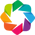

In [89]:
import holoviews as hv
import bokeh
from bokeh.io import curdoc,show
from bokeh.layouts import layout
from bokeh.models import Slider, Button
from bokeh.sampledata import gapminder
from holoviews.plotting.bokeh import BokehRenderer
from bokeh.io import output_file, show#, vplot
from bokeh.plotting import figure
import pandas as pd
import holoviews as hv
hv.extension('bokeh')

%opts Graph [tools=['hover']]

### Variance and Mean analysis

In [ ]:
#Paths
FILES_PATH='/Users/laurieprelot/Documents/EPFL I/S3/3-Applied Data Analysis/DATASETS_ADA/'
FreqTable_Day=pickle.load(open(FILES_PATH+ 'FreqTab_Trump_notbias_BiTri0.9.pkl','rb'))

#Reshape
FreqTable_Day.index=FreqTable_Day['feature']
FreqTable_Day.drop('feature',axis=1,inplace=True)


In [ ]:
#For each word calculate the Mean TFIDF and Variance TFIDF across months
VarTable=pd.DataFrame(FreqTable_Day.var(axis=1, skipna=True),columns=['Word_Var'])
MeanTable=pd.DataFrame(FreqTable_Day.mean(axis=1, skipna=True),columns=['Word_mean'])

#Choose words Based on high Variance and high mean Value 
CommunTable=MeanTable*VarTable
CommunTable['Word_Var']=VarTable['Word_Var']
CommunTable['Word_mean']=MeanTable['Word_mean']
CommunTable['product']=CommunTable['Word_mean'] * CommunTable['Word_Var']
CommunTable2=CommunTable.sort_values(by='product', ascending=False)

In [ ]:
#Plot mean and Variance Space
with sns.axes_style("white"):
    sns.jointplot(x=np.log(VarTable['Word_Var']), y=np.log(MeanTable['Word_mean']), kind="kde", color="k");

Then we look at the Top 400 words in term of Variance and Mean and select manually high mean high variance terms

In [10]:
#Look at the Top 400 words in term of Variance and Mean and select manually. For scaling issues we separate words and candidates
CHOICEWORDS=[
    #'trump',
 #'clinton',
 'republican',
 'obama',
 'woman',
 'school',
 #'hillary',
 'world',
 #'sanders',
 'public',
 'company',
 'democratic',
'international',
 'issue',
 'change',
 'police',
 'student',
 'democrat',
 'business',
 'university',
 'media',
 'debate',
 'black',
 'family',
# 'cruz',
 'community',
# 'bush',
 'gop',
 'health',
 'security',
 'college',
 'nation',
 'gun',
 'market',
 'social',
 'bank',
 'young',
 'press',
 'muslim',
# 'rubio',
 'education',
 'justice',
 'dollar',
 'immigration',
 'china',
 'worker',
 'financial',
 'islamic',
 'industry',
 'trade',
 'online',
 'immigrant']

### Heat Map of top words selected (excluding candidates)

In [8]:
FILES_PATH='/Users/laurieprelot/Documents/EPFL I/S3/3-Applied Data Analysis/DATASETS_ADA/'
FreqTable_Day=pickle.load(open(FILES_PATH+ 'FreqTab_Trump_notbias_BiTri0.9.pkl','rb'))
FreqTable_Day=FreqTable_Day.drop('cum_freq',1)


#Reshape
HeatMapData = pd.melt(FreqTable_Day, id_vars=['feature'], var_name='Date', value_name='Frequency')
HeatMapData=HeatMapData.iloc[:,[1,0,2]]
HeatMapData.set_index(HeatMapData['feature'],inplace=True)
HeatMapData.rename(columns={'feature':'Word'},inplace=True)
HeatMapData['Date']=['20'+ str(i[:3])+ str(i[3:])for i in HeatMapData['Date']]

In [13]:
#Select top words for variance and mean exclusing candidates
HeatMapData1=HeatMapData.loc[CHOICEWORDS]
HeatMapData1.reset_index(drop=True,inplace=True)

#Heat Map Plot top words for variance and mean exclusing candidates
heatmap = hv.HeatMap(HeatMapData1, label='Main Word Frequencies from January 2015 to October 2016')
aggregate = hv.Dataset(heatmap).aggregate('Date', np.mean, np.std)

agg = hv.ErrorBars(aggregate) * hv.Curve(aggregate)

hm_opts = dict(width=900, height=900, tools=['hover'], logz=False, invert_yaxis=False,
            xrotation=90, labelled=[], toolbar='above', xaxis='bottom' ,colorbar=True,colorbar_opts={"width": 10})
overlay_opts = dict(width=900, height=200, show_title=False)
vline_opts = dict(line_color='black')
#hm_style = {"cmap": "viridis"}

#opts = {'HeatMap': {'plot': hm_opts,"style": hm_style}, 'Overlay': {'plot': overlay_opts}, 'VLine': {'style': vline_opts}}
opts = {'HeatMap': {'plot': hm_opts}, 'Overlay': {'plot': overlay_opts}, 'VLine': {'style': vline_opts}}

(heatmap ).opts(opts)


:HeatMap   [Date,Word]   (Frequency)

In [ ]:
#Save to html 
renderer = hv.renderer('bokeh')

# Convert to bokeh figure then save using bokeh
plot = renderer.get_plot((heatmap ).opts(opts)).state

from bokeh.io import output_file, save, show
save(plot, 'HeatMap_Word_per_Date.html')


### Heat Map of Candidates Names over Time

In [14]:
CANDIDATES=['trump','clinton','sanders','cruz','bush','rubio','carson']

In [15]:
FILES_PATH='/Users/laurieprelot/Documents/EPFL I/S3/3-Applied Data Analysis/DATASETS_ADA/'
FreqTable_Day=pickle.load(open(FILES_PATH+ 'FreqTab_Trump_notbias_BiTri0.9.pkl','rb'))
FreqTable_Day=FreqTable_Day.drop('cum_freq',1)


#Reshape
HeatMapData = pd.melt(FreqTable_Day, id_vars=['feature'], var_name='Date', value_name='Frequency')
HeatMapData=HeatMapData.iloc[:,[1,0,2]]
HeatMapData.set_index(HeatMapData['feature'],inplace=True)
HeatMapData.rename(columns={'feature':'Word'},inplace=True)
HeatMapData['Date']=['20'+ str(i[:3])+ str(i[3:])for i in HeatMapData['Date']]

In [17]:
HeatMapData.head()

Date     Word  Frequency
feature                             
year     2015-01     year   0.027275
trump    2015-01    trump   0.001302
state    2015-01    state   0.016179
clinton  2015-01  clinton   0.005952
people   2015-01   people   0.012075

In [18]:
#Select candidates
HeatMapData2=HeatMapData.loc[CANDIDATES]
HeatMapData2.reset_index(drop=True,inplace=True)


#Heat Map Plot top words for variance and mean exclusing candidates
heatmap = hv.HeatMap(HeatMapData2, label='Candidates Name Frequency per Month')
aggregate = hv.Dataset(heatmap).aggregate('Date', np.mean, np.std)
#vline = hv.VLine(6)
marker = hv.Text('2015-05', 0.020, 'June Trump Candidacy', halign='left')
agg = hv.ErrorBars(aggregate) * hv.Curve(aggregate)
hm_opts = dict(width=900, height=300, tools=['hover'], logz=False, invert_yaxis=False,
            xrotation=90, labelled=['2015-05'], toolbar='above', xaxis='bottom',colorbar=True,colorbar_opts={"width": 10})
overlay_opts = dict(width=900, height=200, show_title=False,xrotation=90)
vline_opts = dict(line_color='black',line_dash='dotted', line_alpha=0.5,alpha=1)

opts = {'HeatMap': {'plot': hm_opts}, 'Overlay': {'plot': overlay_opts}, 'VLine': {'style': vline_opts}}

(heatmap + agg * marker).opts(opts).cols(1)

:Layout
   .HeatMap.Candidates_Name_Frequency_per_Month :HeatMap   [Date,Word]   (Frequency)
   .Overlay.Candidates_Name_Frequency_per_Month :Overlay
      .ErrorBars.Candidates_Name_Frequency_per_Month :ErrorBars   [Date]   (Frequency,Frequency_std)
      .Curve.Candidates_Name_Frequency_per_Month     :Curve   [Date]   (Frequency,Frequency_std)
      .Text.I                                        :Text   [x,y]

In [19]:
# Graph to html 
renderer = hv.renderer('bokeh')

# Convert to bokeh figure then save using bokeh
plot = renderer.get_plot((heatmap + agg * marker).opts(opts).cols(1)).state

from bokeh.io import output_file, save, show
save(plot, 'HeatMap_Candidate_per_Date2.html')



'/Users/laurieprelot/Downloads/HeatMap_Candidate_per_Date2.html'

We also conducted an analysis of Word Frequency per Newspaper over time, but unfortunately most of the matrix were highly sparse and did not allow us to compare newspapers with a heatmap. 

# 6. Plot analyzing Word Frequencies deending on Newspaper circulation in the USA and Month

Next we decided to take into account the circulation of the newspaper. This variable was inferend from the numbre of Newspapers present in the Corpus NOW and was verified on internet. The following plot will integrate 4 Layers of information 

In [59]:
from bokeh.io import curdoc
from bokeh.layouts import layout
from bokeh.models import Slider, Button
from bokeh.sampledata import gapminder
from holoviews.plotting.bokeh import BokehRenderer
from bokeh.io import output_file, show#, vplot
from bokeh.plotting import figure

In [60]:
os.chdir('/Users/laurieprelot/Documents/EPFL I/S3/3-Applied Data Analysis/DATASETS_ADA/')
full_Freqtable=pickle.load(open('ALLFINAL_Freq_perNP_perDay_0.5.pkl','rb'))

In [61]:
#Words To choose for the Plot. There were obtained from our list of 400 words
ListWords=[
 'woman',
 'school',
 'tax',
 'police',
 'debate',
 'health',
 'muslim',
 'immigration',
]

In [62]:
#Formatting

#Format Date
full_Freqtable['Date']=full_Freqtable['Date'].map(lambda x: float('20'+str(x[:2]) +'.'+str(x[3:])))#.map(lambda x: x.lstrip('+-').rstrip('aAbBcC'))
#Choose words
plotfull_Freqtable=full_Freqtable[full_Freqtable['Word'].isin(ListWords)]
#Rescale Bias
plotfull_Freqtable['Bias']=(plotfull_Freqtable['Bias']+3)
#Chanege Names
plotfull_Freqtable=plotfull_Freqtable.rename(columns={'Bias':'Political Orientation (Far Left: 0 to Far Right: 5)'})
plotfull_Freqtable.columns

Index(['Word', 'Freq_PerMonth_PerDate', 'Date', 'Source', 'Number_Article',
       'Political Orientation (Far Left: 0 to Far Right: 5)'],
      dtype='object')

In [58]:
plotfull_Freqtable.head()

Word  Freq_PerMonth_PerDate     Date          Source  Number_Article  \
87120  tax               0.003350  2015.01    The Atlantic             541   
87121  tax                    NaN  2015.01  The New Yorker             146   
87122  tax               0.013048  2015.01             CNN             382   
87123  tax               0.007697  2015.01        CBS News             255   
87124  tax                    NaN  2015.01     NBCNews.com             367   

       Political Orientation (Far Left: 0 to Far Right: 5)  
87120                                                2.0    
87121                                                1.0    
87122                                                3.0    
87123                                                2.0    
87124                                                2.0

In [84]:
#Create the 4D Plot integrating frequency of words, circulation of Newspapers, Political orientation and Time

ds = hv.Dataset(plotfull_Freqtable)
# Apply dimension labels and ranges
kdims = ['Number_Article', 'Freq_PerMonth_PerDate']
vdims = ['Word', 'Political Orientation (Far Left: 0 to Far Right: 5)', 'Word']
dimensions = {
    'Number_Article' : dict(label='Newspapers Ranked per Circulation in the US (Relative Value) ', range=(min(plotfull_Freqtable['Number_Article']), max(plotfull_Freqtable['Number_Article'])+20)),
    'Freq_PerMonth_PerDate': dict(label= 'Frequency (TF-IDF per Newspaper and per Date)', range=(0, 0.12)),
    'Political Orientation (Far Left: 0 to Far Right: 5)': ('Political Orientation (Far Left: 0 to Far Right: 5)', 'Political Orientation (Far Left: 0 to Far Right: 5)')
}

# Create Points plotting fertility vs life expectancy indexed by Year
gapminder_ds = ds.redim(**dimensions).to(hv.Points, kdims, vdims, 'Date')

# Define annotations
text = gapminder_ds.clone({yr: hv.Text(150, 0.11, str(yr), fontsize=5)
                           for yr in gapminder_ds.keys()})

# Define options
opts = {'plot': dict(width=1000, height=600,tools=['hover'], size_index='Political Orientation (Far Left: 0 to Far Right: 5)',
                     color_index='Word', size_fn=np.sqrt, title_format="{label}"),
       'style': dict(cmap='Set1', size=16, line_color='black', alpha=0.7)}
text_opts = {'style': dict(text_font_size='52pt', text_color='lightgray')}


# Combine Points and Text
hvgapminder=(gapminder_ds({'Points': opts}) * text({'Text': text_opts})).relabel('Frequency of Election-Related Words and Newspaper Impact')

In [85]:
# Define custom widgets
def animate_update():
    year = slider.value + 1
    if year > end:
        year = start
    slider.value = year

# Update the holoviews plot by calling update with the new year.
def slider_update(attrname, old, new):
    hvplot.update((new,))

def animate():
    if button.label == '► Play':
        button.label = '❚❚ Pause'
        doc.add_periodic_callback(animate_update, 200)
    else:
        button.label = '► Play'
        doc.remove_periodic_callback(animate_update)

#start, end = ds.range('Year')
slider = Slider(start=2015.01, end=2016.10, value=2015.01, step=0.1, title="Month")
slider.on_change('value', slider_update)
        
button = Button(label='► Play', width=60)
button.on_click(animate)

# Get HoloViews plot and attach document
doc = curdoc()
hvplot = BokehRenderer.get_plot(hvgapminder, doc)

# Make a bokeh layout and add it as the Document root
plot = layout([[hvplot.state], [slider, button]], sizing_mode='fixed')
doc.add_root(plot)


In [86]:
(gapminder_ds({'Points': opts}) * text({'Text': text_opts})).relabel('Frequency of Election-Related Words and Newspaper Impact')

:HoloMap   [Date]
   :Overlay
      .Points.I :Points   [Number_Article,Freq_PerMonth_PerDate]   (Word,Political Orientation (Far Left: 0 to Far Right: 5),Word)
      .Text.I   :Text   [x,y]

In [87]:
renderer = hv.renderer('bokeh')
#Using renderer save
renderer.save(hvgapminder, 'Election-Relatedwords.html')